In [ ]:
!pip install pyswarms

     |████████████████████████████████| 102kB 4.2MB/s 


In [ ]:
import pyswarms as ps

import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

import time

from scipy.integrate import odeint,simps

In [ ]:
Cva=0.0824 #kmol/m3
Cbv=1.5324 #kmol/m3
Ccv=0 #kmol/m3
q=0.0720 #m3/min
qc=0.6307  #m3/min
ro=974.19 #kg/m3
roc=998 #kg/m3
Cp=3.7187 #kJ/(kg*K)
Cpc=4.182#kJ/(kg*K)
V=2.407 #m3
Vc=2 #m3
A=8.695 #m2
alpha=13.8 #kJ/(min*m2*K)
Tv=299.05 #K
Tvc=288.15 #K
g=10183 #K
DrH=-5.46e6 #kJ/kmol
kinf=2.8233e11 #min-1

#Inicialmente....
Ca=Cva
T=Tv
Tc=Tvc
#Leitura dos dados
data=pd.read_csv('Dados_gerados_case_geral_t_2_v2', sep='\t', encoding='utf-8',header=None)

data.columns=['Tvc_','T_','Tvc_t-1','T_t-1','Tvc_t-2','T_t-2']

#data=data.drop(['qc_','Tv_','Tvc_','q_'],axis=1)

data=data.dropna()

#---------------------------------------------------------------------------------------


#Definição de targets

#target_tc=data.pop('Tc_')
#target_ca=data.pop('Ca_')
target=data.pop('T_')
_=data.pop('Tvc_')
#Padronização dos dados
scaler=StandardScaler()

entrada=scaler.fit_transform(data)

2020-12-17 10:24:12,539 - numexpr.utils - INFO - NumExpr defaulting to 2 threads.


In [ ]:
model = tf.keras.models.load_model('Treino_GRU_v2.h5')

In [47]:



def J(u):   
    """
    u=Tvc[t-1,t,t+1]
    model = rede neural treinada
    h_pred = horizonte de predição
    h_contr = horizonte de controle
    SP = Set-point
    """
    global model,h_pred,SP,Tvc_t_1,T_t_1,Tvc_t_2,T_t_2,T_t_1_,T_,Tvc_t_2_,T_t_2_,T_t_1_
    #Parâmetro referente ao controlador (verificar artigos)
    wT=0.1
    lambda_q=10

#    start_time = time.time()
#    Loop para cálculo do horizonte de predição
    
    #Informação do Tvc para ser utilizado no df 'd_Tvc'
    Tvc_t_2_=Tvc_t_2
    
    T_t_2_=T_t_2
    T_t_1_=T_t_1
    
    T_=[]
    
    for i in range(h_pred):
        
        if i<3:
          
            T_.append(float(model(np.asarray([np.ndarray.tolist(scaler.transform([[u[i],
                                                                                   T_t_1_,Tvc_t_2_,T_t_2_]]))]),training=False)))
            Tvc_t_2_=u[i]
            
            T_t_2_=T_t_1_
            T_t_1_=T_[i]
            
        else:
            T_.append(float(model(np.asarray([np.ndarray.tolist(scaler.transform([[u[3],
                                                                               T_t_1_,Tvc_t_2_,T_t_2_]]))]),training=False)))
            Tvc_t_2_=u[3]
            
            T_t_2_=T_t_1_
            T_t_1_=T_[i]
            
#    print("--- %s seconds ---" % (time.time() - start_time))
   
    #Array com os set points no decorrer da predição
    y_ref=[SP]*h_pred
    
    #Horizonte de controle (3)
    d_Tvc=[]
    d_Tvc.append((u[0]-Tvc_t_2_)**2)
    d_Tvc.append((u[1]-u[0])**2)
    d_Tvc.append((u[2]-u[1])**2)
    d_Tvc.append((u[3]-u[2])**2)
    
       
    #função objetivo
    obj=wT*sum((pd.Series(y_ref)-pd.Series(T_))**2)+lambda_q*sum(pd.Series(d_Tvc))
    
    return obj

#EDO do sistema (cstr)
def plant(z,t):
    global q,Cva,V,kinf,g,Tv,alpha,A,ro,Cp,DrH,qc,Tvc,Vc,roc,Cpc
    Ca  = z[0]
    T   = z[1]
    Tc  = z[2]
    
    dCadt=(q*(Cva-Ca)/V)-(kinf*np.exp(-g/T)*Ca)
    dTdt=((Tv-T)*q/V) -(alpha*A*(T-Tc)/(V*ro*Cp))+(kinf*np.exp(-g/T)*Ca*(-DrH)/(ro*Cp))
    dTcdt=(qc*(Tvc-Tc)/Vc)+(alpha*A*(T-Tc)/(Vc*roc*Cpc))
    dzdt = [dCadt,dTdt,dTcdt]
    
    return dzdt


In [48]:

#FO
qc_t_1=0.6307
Tv_t_1=299.05
Tvc_t_1=288.15
q_t_1=0.072
T_t_1=296.7227
qc_t_2=0.6307
Tv_t_2=299.05
Tvc_t_2=288.15
q_t_2=0.072
T_t_2=296.7227

#Condições iniciais da EDO (partindo do estado estacionário)
Ca=0.0814416
T=296.7227
Tc=288.5237
Tvc=288.15

Tv=299.05 #K
#---------------------
#Entradas - Horizonte de predição e Set-point
h_pred=8
SP=298

z_=[]
z0 = [Ca,T,Tc]
Tvc_=[]
sp_=[]

u=[288.15,288.15,288.15,288.15]
					
def min_f(particles):
        return [J(particle) for particle in particles]
    
    
constraints = (np.array([275,275,275,275]),
               np.array([310,310,310,310]))

In [49]:
start_time = time.time()
final_step=50
for i in range(final_step):
     
    if i==25:
        SP=297
    
    options={'c1':2,'c2':2,'w':0.5}
    optimizer=ps.single.GlobalBestPSO(n_particles=50,dimensions=4,options=options,bounds=constraints)
    popt=optimizer.optimize(min_f,iters=50)
    
    
    Tvc=popt[1][0]
    Tvc_.append(Tvc)
    #Intervalos de tempo para a integração
    t = np.linspace(0,1,2)
    
    z_.append(np.ndarray.tolist(odeint(plant,z0,t)[1]))
    
    z0=z_[-1]
    
#    Atualização do valor para a próxima iteração
    Tvc_t_2=Tvc_t_1
    Tvc_t_1=Tvc

    
    T_t_2=T_t_1
    T_t_1=z0[1]
    
    u=popt[1]
    
    print(z_)
    print('\n')
    print(T_)
    
    print('\n %.1f %%'%(i*100/final_step))
    print(70*'=')
    
    sp_.append(SP)
    
print("--- %s seconds ---" % (time.time() - start_time))

2020-12-17 16:19:22,012 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}

pyswarms.single.global_best:   0%|          |0/50
pyswarms.single.global_best:   0%|          |0/50, best_cost=391
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=391
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=229
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=229
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=141
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=141
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=19 
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=19
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=19
pyswarms.single.global_best:  10%|█         |5/50, best_cost=19
pyswarms.single.global_best:  10%|█         |5/50, best_cost=19
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=19
pyswarms.single.global_best:  12%|█▏        |6/50, best

[[0.0814415999949708, 296.7239109750816, 288.6929806660832]]


[296.7544860839844, 296.8188171386719, 296.88482666015625, 296.9705505371094, 297.0780029296875, 297.1993103027344, 297.328857421875, 297.4627685546875]

 0.0 %



pyswarms.single.global_best:   0%|          |0/50, best_cost=62.1
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=62.1
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=50.6
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=50.6
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=45.9
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=45.9
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=10  
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=10
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=10
pyswarms.single.global_best:  10%|█         |5/50, best_cost=10
pyswarms.single.global_best:  10%|█         |5/50, best_cost=2.9
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=2.9
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=2.65
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=2.65
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=2.65
pyswarms.single.g

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664]]


[296.8363952636719, 297.05072021484375, 297.3363037109375, 297.5694580078125, 297.7293395996094, 297.8372802734375, 297.908447265625, 297.95361328125]

 2.0 %



pyswarms.single.global_best:   0%|          |0/50, best_cost=289
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=289
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=40.5
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=40.5
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=40.5
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=40.5
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=40.5
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=40.5
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=8.77
pyswarms.single.global_best:  10%|█         |5/50, best_cost=8.77
pyswarms.single.global_best:  10%|█         |5/50, best_cost=8.77
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=8.77
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=3.07
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=3.07
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=1.59
pyswarms.si

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485]]


[296.8699035644531, 297.0448913574219, 297.2638244628906, 297.51104736328125, 297.77545166015625, 298.04962158203125, 298.32916259765625, 298.611572265625]

 4.0 %



pyswarms.single.global_best:   0%|          |0/50, best_cost=67.9
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=67.9
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=67.8
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=67.8
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=67.8
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=67.8
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=67.8
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=67.8
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=65.4
pyswarms.single.global_best:  10%|█         |5/50, best_cost=65.4
pyswarms.single.global_best:  10%|█         |5/50, best_cost=59.4
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=59.4
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=56.7
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=56.7
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=55.5
pyswarms.

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025]]


[296.96124267578125, 297.1178894042969, 297.28857421875, 297.4359130859375, 297.5571594238281, 297.6592102050781, 297.7471923828125, 297.82489013671875]

 6.0 %



pyswarms.single.global_best:   0%|          |0/50, best_cost=350
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=350
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=350
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=350
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=350
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=350
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=24.5
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=24.5
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=24.5
pyswarms.single.global_best:  10%|█         |5/50, best_cost=24.5
pyswarms.single.global_best:  10%|█         |5/50, best_cost=24.5
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=24.5
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=24.5
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=24.5
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=17.1
pyswarms.single

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361]]


[296.9601135253906, 296.9602966308594, 297.04046630859375, 297.2208557128906, 297.4734191894531, 297.7737731933594, 298.1048278808594, 298.455322265625]

 8.0 %



pyswarms.single.global_best:   0%|          |0/50, best_cost=1.31e+3
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=1.31e+3
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=120    
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=120
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=87 
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=87
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=67.1
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=67.1
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=67.1
pyswarms.single.global_best:  10%|█         |5/50, best_cost=67.1
pyswarms.single.global_best:  10%|█         |5/50, best_cost=67.1
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=67.1
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=67.1
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=67.1
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=58  
pysw

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844]]


[297.00897216796875, 297.0684814453125, 297.1277160644531, 297.2672119140625, 297.4881896972656, 297.7641296386719, 298.0761413574219, 298.4114685058594]

 10.0 %



pyswarms.single.global_best:   0%|          |0/50, best_cost=59.3
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=59.3
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=59.3
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=59.3
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=47.7
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=47.7
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=29.3
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=29.3
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=29.3
pyswarms.single.global_best:  10%|█         |5/50, best_cost=29.3
pyswarms.single.global_best:  10%|█         |5/50, best_cost=29.3
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=29.3
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=14.1
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=14.1
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=14.1
pyswarms.

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193]]


[297.04400634765625, 297.1448059082031, 297.2740478515625, 297.42242431640625, 297.5829772949219, 297.7507019042969, 297.9223327636719, 298.0958557128906]

 12.0 %



pyswarms.single.global_best:   0%|          |0/50, best_cost=286
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=286
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=39.3
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=39.3
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=39.3
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=39.3
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=11.3
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=11.3
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=11.3
pyswarms.single.global_best:  10%|█         |5/50, best_cost=11.3
pyswarms.single.global_best:  10%|█         |5/50, best_cost=2.85
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=2.85
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=2.85
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=2.85
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=2.85
pyswarms.si

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033]]


[297.17889404296875, 297.3362121582031, 297.51068115234375, 297.6959533691406, 297.88763427734375, 298.08270263671875, 298.27935791015625, 298.4765625]

 14.0 %



pyswarms.single.global_best:   0%|          |0/50, best_cost=433
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=433
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=203
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=203
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=111
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=111
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=111
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=111
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=111
pyswarms.single.global_best:  10%|█         |5/50, best_cost=111
pyswarms.single.global_best:  10%|█         |5/50, best_cost=111
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=111
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=84.6
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=84.6
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=84.6
pyswarms.single.globa

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088]]


[297.2563171386719, 297.4007568359375, 297.5934143066406, 297.72613525390625, 297.7747802734375, 297.7644348144531, 297.7127380371094, 297.6321105957031]

 16.0 %



pyswarms.single.global_best:   0%|          |0/50, best_cost=285
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=285
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=206
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=206
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=79.9
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=79.9
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=79.9
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=79.9
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=57.9
pyswarms.single.global_best:  10%|█         |5/50, best_cost=57.9
pyswarms.single.global_best:  10%|█         |5/50, best_cost=57.9
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=57.9
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=17.5
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=17.5
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=14.1
pyswarms.sing

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689]]


[297.2518615722656, 297.2876281738281, 297.3168029785156, 297.35614013671875, 297.4082336425781, 297.4688720703125, 297.5350646972656, 297.6047058105469]

 18.0 %



pyswarms.single.global_best:   0%|          |0/50, best_cost=822
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=822
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=222
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=222
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=222
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=222
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=60 
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=60
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=17.6
pyswarms.single.global_best:  10%|█         |5/50, best_cost=17.6
pyswarms.single.global_best:  10%|█         |5/50, best_cost=2.23
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=2.23
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=2.23
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=2.23
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=2.23
pyswarms.single.gl

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513]]


[297.4793701171875, 297.6681213378906, 297.87353515625, 298.05096435546875, 298.19390869140625, 298.3123779296875, 298.4134216308594, 298.5019836425781]

 20.0 %



pyswarms.single.global_best:   0%|          |0/50, best_cost=454
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=454
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=215
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=215
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=139
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=139
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=139
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=139
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=111
pyswarms.single.global_best:  10%|█         |5/50, best_cost=111
pyswarms.single.global_best:  10%|█         |5/50, best_cost=57.6
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=57.6
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=57.6
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=57.6
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=40.7
pyswarms.single.glo

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933]]


[297.5653991699219, 297.6650695800781, 297.7946472167969, 297.9677734375, 298.1716003417969, 298.3961486816406, 298.6346130371094, 298.88238525390625]

 22.0 %



pyswarms.single.global_best:   0%|          |0/50, best_cost=832
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=832
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=315
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=315
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=119
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=119
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=119
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=119
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=75.7
pyswarms.single.global_best:  10%|█         |5/50, best_cost=75.7
pyswarms.single.global_best:  10%|█         |5/50, best_cost=75.7
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=75.7
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=11.8
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=11.8
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=11.8
pyswarms.single.g

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653]]


[297.69061279296875, 297.85626220703125, 298.0355224609375, 298.2250671386719, 298.4215087890625, 298.6223449707031, 298.8258972167969, 299.03106689453125]

 24.0 %



pyswarms.single.global_best:   0%|          |0/50, best_cost=274
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=274
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=274
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=274
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=255
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=255
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=255
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=255
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=135
pyswarms.single.global_best:  10%|█         |5/50, best_cost=135
pyswarms.single.global_best:  10%|█         |5/50, best_cost=92.4
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=92.4
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=42.7
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=42.7
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=42.7
pyswarms.single.glo

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236]]


[297.8084411621094, 298.01263427734375, 298.2457275390625, 298.498291015625, 298.7640075683594, 299.0386047363281, 299.3193054199219, 


pyswarms.single.global_best:   0%|          |0/50, best_cost=171
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=171
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=156
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=156
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=150
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=150
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=147
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=147
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=145
pyswarms.single.global_best:  10%|█         |5/50, best_cost=145
pyswarms.single.global_best:  10%|█         |5/50, best_cost=144
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=144
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=144
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=144
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=144
pyswarms.single.global_b

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533]]


[297.91143798828125, 298.1309814453125, 298.32684326171875, 298.43371582


pyswarms.single.global_best:   0%|          |0/50, best_cost=443
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=443
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=443
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=443
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=123
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=123
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=75.4
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=75.4
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=75.4
pyswarms.single.global_best:  10%|█         |5/50, best_cost=75.4
pyswarms.single.global_best:  10%|█         |5/50, best_cost=75.4
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=75.4
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=48.8
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=48.8
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=48.8
pyswarms.single

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745]]


[297.873687


pyswarms.single.global_best:   0%|          |0/50, best_cost=1.31e+3
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=1.31e+3
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=138    
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=138
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=41.4
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=41.4
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=41.4
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=41.4
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=41.4
pyswarms.single.global_best:  10%|█         |5/50, best_cost=41.4
pyswarms.single.global_best:  10%|█         |5/50, best_cost=41.4
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=41.4
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=41.4
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=41.4
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=41.4
p

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=480
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=480
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=470
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=470
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=187
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=187
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=76.2
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=76.2
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=21.7
pyswarms.single.global_best:  10%|█         |5/50, best_cost=21.7
pyswarms.single.global_best:  10%|█         |5/50, best_cost=21.7
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=21.7
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=21.7
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=21.7
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=21.7
pyswarms.single

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=804
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=804
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=44.4
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=44.4
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=17.2
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=17.2
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=17.2
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=17.2
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=17.2
pyswarms.single.global_best:  10%|█         |5/50, best_cost=17.2
pyswarms.single.global_best:  10%|█         |5/50, best_cost=17.2
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=17.2
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=17.2
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=17.2
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=8.6 
pyswarms.si

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=212
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=212
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=181
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=181
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=168
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=168
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=162
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=162
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=96.5
pyswarms.single.global_best:  10%|█         |5/50, best_cost=96.5
pyswarms.single.global_best:  10%|█         |5/50, best_cost=96.5
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=96.5
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=96.5
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=96.5
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=96.5
pyswarms.single.g

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=259
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=259
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=194
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=194
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=163
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=163
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=146
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=146
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=62.4
pyswarms.single.global_best:  10%|█         |5/50, best_cost=62.4
pyswarms.single.global_best:  10%|█         |5/50, best_cost=29.1
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=29.1
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=29.1
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=29.1
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=27  
pyswarms.single.g

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=1.76e+3
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=1.76e+3
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=169    
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=169
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=169
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=169
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=87.3
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=87.3
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=66.4
pyswarms.single.global_best:  10%|█         |5/50, best_cost=66.4
pyswarms.single.global_best:  10%|█         |5/50, best_cost=6.44
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=6.44
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=6.44
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=6.44
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=6.44
pys

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=393
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=393
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=243
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=243
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=176
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=176
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=52.5
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=52.5
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=4.49
pyswarms.single.global_best:  10%|█         |5/50, best_cost=4.49
pyswarms.single.global_best:  10%|█         |5/50, best_cost=4.49
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=4.49
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=2.19
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=2.19
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=2.19
pyswarms.single

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=74.2
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=74.2
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=59.1
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=59.1
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=52.6
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=52.6
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=44.4
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=44.4
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=3.76
pyswarms.single.global_best:  10%|█         |5/50, best_cost=3.76
pyswarms.single.global_best:  10%|█         |5/50, best_cost=3.76
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=3.76
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=3.76
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=3.76
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=3.76
pyswarms.

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=563
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=563
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=134
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=134
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=84.6
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=84.6
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=84.6
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=84.6
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=84.6
pyswarms.single.global_best:  10%|█         |5/50, best_cost=84.6
pyswarms.single.global_best:  10%|█         |5/50, best_cost=84.6
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=84.6
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=84.6
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=84.6
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=84.6
pyswarms.sing

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=853
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=853
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=458
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=458
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=94.5
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=94.5
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=94.5
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=94.5
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=94.5
pyswarms.single.global_best:  10%|█         |5/50, best_cost=94.5
pyswarms.single.global_best:  10%|█         |5/50, best_cost=94.5
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=94.5
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=90.3
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=90.3
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=40.8
pyswarms.sing

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=2.54e+3
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=2.54e+3
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=202    
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=202
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=202
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=202
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=76.8
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=76.8
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=76.8
pyswarms.single.global_best:  10%|█         |5/50, best_cost=76.8
pyswarms.single.global_best:  10%|█         |5/50, best_cost=76.8
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=76.8
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=76.8
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=76.8
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=76.8
pys

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=1.6e+3
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=1.6e+3
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=60.4  
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=60.4
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=60.4
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=60.4
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=60.4
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=60.4
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=60.4
pyswarms.single.global_best:  10%|█         |5/50, best_cost=60.4
pyswarms.single.global_best:  10%|█         |5/50, best_cost=18.5
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=18.5
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=16.6
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=16.6
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=2.7 
pys

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=27.8
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=27.8
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=27.8
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=27.8
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=17.9
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=17.9
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=15.6
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=15.6
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=15.6
pyswarms.single.global_best:  10%|█         |5/50, best_cost=15.6
pyswarms.single.global_best:  10%|█         |5/50, best_cost=15.6
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=15.6
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=5.05
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=5.05
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=5.05
pyswarms.

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=1.86e+3
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=1.86e+3
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=793    
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=793
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=23.6
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=23.6
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=23.6
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=23.6
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=4.81
pyswarms.single.global_best:  10%|█         |5/50, best_cost=4.81
pyswarms.single.global_best:  10%|█         |5/50, best_cost=4.81
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=4.81
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=4.81
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=4.81
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=4.81
p

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=1.25e+3
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=1.25e+3
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=141    
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=141
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=115
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=115
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=48.4
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=48.4
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=48.4
pyswarms.single.global_best:  10%|█         |5/50, best_cost=48.4
pyswarms.single.global_best:  10%|█         |5/50, best_cost=39.3
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=39.3
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=30.6
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=30.6
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=28  
pys

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=272
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=272
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=272
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=272
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=272
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=272
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=247
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=247
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=234
pyswarms.single.global_best:  10%|█         |5/50, best_cost=234
pyswarms.single.global_best:  10%|█         |5/50, best_cost=229
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=229
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=226
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=226
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=121
pyswarms.single.global_b

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=795
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=795
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=162
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=162
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=155
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=155
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=155
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=155
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=20.6
pyswarms.single.global_best:  10%|█         |5/50, best_cost=20.6
pyswarms.single.global_best:  10%|█         |5/50, best_cost=9.48
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=9.48
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=9.48
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=9.48
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=9.48
pyswarms.single.g

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=1.37e+3
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=1.37e+3
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=130    
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=130
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=130
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=130
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=130
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=130
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=130
pyswarms.single.global_best:  10%|█         |5/50, best_cost=130
pyswarms.single.global_best:  10%|█         |5/50, best_cost=130
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=130
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=130
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=130
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=15.2
pyswarms.si

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=765
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=765
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=456
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=456
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=456
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=456
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=345
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=345
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=204
pyswarms.single.global_best:  10%|█         |5/50, best_cost=204
pyswarms.single.global_best:  10%|█         |5/50, best_cost=204
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=204
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=144
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=144
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=144
pyswarms.single.global_b

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=1.1e+3
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=1.1e+3
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=163   
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=163
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=163
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=163
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=163
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=163
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=94.7
pyswarms.single.global_best:  10%|█         |5/50, best_cost=94.7
pyswarms.single.global_best:  10%|█         |5/50, best_cost=94.7
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=94.7
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=44.3
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=44.3
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=44.3
pyswarms

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=380
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=380
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=123
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=123
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=64 
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=64
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=64
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=64
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=64
pyswarms.single.global_best:  10%|█         |5/50, best_cost=64
pyswarms.single.global_best:  10%|█         |5/50, best_cost=64
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=64
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=64
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=64
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=53.5
pyswarms.single.global_best:  16

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=184
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=184
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=184
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=184
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=143
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=143
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=40.4
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=40.4
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=29.9
pyswarms.single.global_best:  10%|█         |5/50, best_cost=29.9
pyswarms.single.global_best:  10%|█         |5/50, best_cost=5.51
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=5.51
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=5.51
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=5.51
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=5.51
pyswarms.single

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=592
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=592
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=44.6
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=44.6
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=44.6
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=44.6
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=44.6
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=44.6
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=44.6
pyswarms.single.global_best:  10%|█         |5/50, best_cost=44.6
pyswarms.single.global_best:  10%|█         |5/50, best_cost=44.6
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=44.6
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=44.6
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=44.6
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=44.6
pyswarms.si

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=527
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=527
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=216
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=216
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=161
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=161
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=161
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=161
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=70.4
pyswarms.single.global_best:  10%|█         |5/50, best_cost=70.4
pyswarms.single.global_best:  10%|█         |5/50, best_cost=43.3
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=43.3
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=15.4
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=15.4
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=6.64
pyswarms.single.g

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=375
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=375
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=375
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=375
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=145
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=145
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=145
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=145
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=118
pyswarms.single.global_best:  10%|█         |5/50, best_cost=118
pyswarms.single.global_best:  10%|█         |5/50, best_cost=43.6
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=43.6
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=16.8
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=16.8
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=16.8
pyswarms.single.glo

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=271
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=271
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=217
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=217
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=217
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=217
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=217
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=217
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=30.3
pyswarms.single.global_best:  10%|█         |5/50, best_cost=30.3
pyswarms.single.global_best:  10%|█         |5/50, best_cost=30.3
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=30.3
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=30.3
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=30.3
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=30.3
pyswarms.single.g

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=752
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=752
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=58.1
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=58.1
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=14.5
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=14.5
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=14.5
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=14.5
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=14.5
pyswarms.single.global_best:  10%|█         |5/50, best_cost=14.5
pyswarms.single.global_best:  10%|█         |5/50, best_cost=14.5
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=14.5
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=6.83
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=6.83
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=6.3 
pyswarms.si

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=189
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=189
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=182
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=182
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=179
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=179
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=178
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=178
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=177
pyswarms.single.global_best:  10%|█         |5/50, best_cost=177
pyswarms.single.global_best:  10%|█         |5/50, best_cost=177
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=177
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=44.9
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=44.9
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=44.9
pyswarms.single.globa

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=20.7
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=20.7
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=20.7
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=20.7
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=20.7
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=20.7
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=15.8
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=15.8
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=15.7
pyswarms.single.global_best:  10%|█         |5/50, best_cost=15.7
pyswarms.single.global_best:  10%|█         |5/50, best_cost=15.7
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=15.7
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=15.7
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=15.7
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=15.5
pyswarms.

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=39.8
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=39.8
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=39.8
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=39.8
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=33.6
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=33.6
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=33.6
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=33.6
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=33.5
pyswarms.single.global_best:  10%|█         |5/50, best_cost=33.5
pyswarms.single.global_best:  10%|█         |5/50, best_cost=10.5
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=10.5
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=10.5
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=10.5
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=10.5
pyswarms.

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=481
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=481
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=351
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=351
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=324
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=324
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=112
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=112
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=105
pyswarms.single.global_best:  10%|█         |5/50, best_cost=105
pyswarms.single.global_best:  10%|█         |5/50, best_cost=105
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=105
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=105
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=105
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=103
pyswarms.single.global_b

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=732
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=732
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=263
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=263
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=167
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=167
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=144
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=144
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=144
pyswarms.single.global_best:  10%|█         |5/50, best_cost=144
pyswarms.single.global_best:  10%|█         |5/50, best_cost=64.3
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=64.3
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=64.3
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=64.3
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=7   
pyswarms.single.glo

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=465
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=465
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=133
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=133
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=133
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=133
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=133
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=133
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=125
pyswarms.single.global_best:  10%|█         |5/50, best_cost=125
pyswarms.single.global_best:  10%|█         |5/50, best_cost=125
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=125
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=125
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=125
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=68.4
pyswarms.single.global_

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503


pyswarms.single.global_best:   0%|          |0/50, best_cost=1.11e+3
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=1.11e+3
pyswarms.single.global_best:   2%|▏         |1/50, best_cost=473    
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=473
pyswarms.single.global_best:   4%|▍         |2/50, best_cost=425
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=425
pyswarms.single.global_best:   6%|▌         |3/50, best_cost=425
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=425
pyswarms.single.global_best:   8%|▊         |4/50, best_cost=417
pyswarms.single.global_best:  10%|█         |5/50, best_cost=417
pyswarms.single.global_best:  10%|█         |5/50, best_cost=254
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=254
pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=108
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=108
pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=108
pyswarms.sin

[[0.0814415999949708, 296.7239109750816, 288.6929806660832], [0.08144155394389668, 296.7612840062705, 293.59848187714664], [0.08144130478070621, 296.8407273765401, 295.3310058248485], [0.08144079299533892, 296.9171066247353, 293.79093491074025], [0.08144010571655572, 296.9491407866751, 289.3656237458361], [0.08143935982259509, 296.98502504500647, 293.9866350074844], [0.08143844948573854, 297.04947328547786, 294.07635467767193], [0.08143734772412956, 297.1148946607508, 294.4726829507033], [0.08143603214969629, 297.1989858431751, 297.0731819411088], [0.08143441260883624, 297.31347044244325, 299.4582921559689], [0.08143242063811208, 297.43336010136693, 298.7043855754513], [0.08143008410386288, 297.5445946062718, 298.79168785113933], [0.08142743291608474, 297.6469542421195, 298.05795606476653], [0.0814245041425809, 297.74544242920797, 298.70162750960236], [0.08142131648574517, 297.8313968792401, 296.89676762357533], [0.08141797639448534, 297.876210857484, 293.19899533577745], [0.0814146503

In [50]:
import matplotlib.pyplot as plt


In [54]:
"""
Plotagem dos resultados
"""
p_=pd.DataFrame(z_)

SAVE_RESULTS=p_.copy()
SAVE_RESULTS['sp']=sp_
SAVE_RESULTS['Tvc']=Tvc_

#SAVE_RESULTS.to_csv('Result_GRU_V7.csv', sep='\t', encoding='utf-8', header=None, index=False)




In [55]:
#Métricas de erro
IAE=simps(abs(sp_-p_[1]))
ISE=simps((sp_-p_[1])**2)
ITAE=simps(np.linspace(0,final_step-1,final_step)*abs(sp_-p_[1]))
ITSE=simps(np.linspace(0,final_step-1,final_step)*((sp_-p_[1])**2))


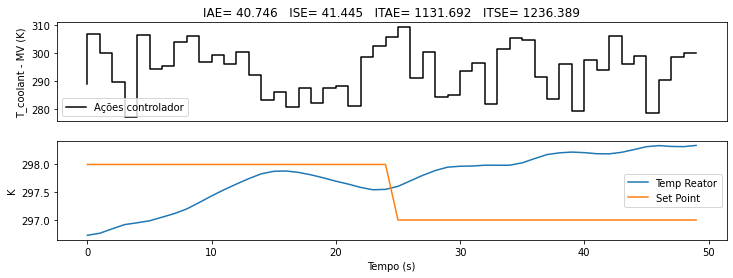

In [56]:

#Plotagem
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.title("IAE= "+'%.3f'%IAE+ "   ISE= "+'%.3f'%ISE+"   ITAE= "+'%.3f'%ITAE+"   ITSE= "+'%.3f'%ITSE)
plt.step(np.linspace(0,final_step-1,final_step),Tvc_,'k',label='Ações controlador')
plt.ylabel('T_coolant - MV (K)')
#plt.xlabel('Tempo (s)')
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.legend()


#plt.figure(figsize=(12,4))
plt.subplot(2,1,2)
plt.plot(p_[1],label='Temp Reator')
plt.plot(sp_,label='Set Point')
plt.ylabel('K')
plt.xlabel('Tempo (s)')

plt.xticks(np.linspace(0,final_step,6))
plt.legend()

plt.show()

